# 下載和引入需要的函式庫

In [1]:
# !pip install --user torch>=1.5.0 editdistance jieba-fast sacrebleu sacremoses sentencepiece tqdm

In [2]:
# !git clone https://github.com/pytorch/fairseq.git
# !cd fairseq && git checkout 9a1c497
# !pip install --upgrade --user fairseq

In [3]:
import sys
import pprint
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO",
    stream=sys.stdout,
)
logger = logging.getLogger("seq2seq")

In [5]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])

2021-02-04 15:07:15 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2021-02-04 15:07:15 | INFO | fairseq.utils | rank   0: capabilities =  7.5  ; total memory = 7.793 GB ; name = GeForce RTX 2070                        
2021-02-04 15:07:15 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 實驗的參數設定表

In [7]:
config = Namespace( # common ?
    datadir = "./seq2seq-nmt/DATA/data-bin/ted2020",
    savedir = "./checkpoints-transformer",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=8,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=4096,
    accum_steps=4,
    # when calculating loss, normalized by number of sentences instead of number of tokens
    sentence_average=False,
    
    # maximum epochs for training
    max_epoch=40,
    start_epoch=21,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # length penalty: <1.0 favors shorter, >1.0 favors longer sentences
    lenpen=1, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    remove_jieba = True,
    
    # checkpoints
    keep_last_epochs = 3,
    resume=None,
)

# 借用fairseq的TranslationTask
* mmap dataset非常之快
* 有現成的 dataloader iterator
* 字典 task.source_dictionary 和 task.target_dictionary 也很好用 
* 有實做 beam search

In [8]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
)
task = TranslationTask.setup_task(task_cfg)

2021-02-04 15:07:15 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2021-02-04 15:07:15 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


# Dataset

In [19]:
# load data into task

# num_workers=8
# max_tokens=4096

def load_data_iterator(task, split, epoch=1, max_tokens=1000, num_workers=1):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=138,
        num_workers=num_workers,
        epoch=epoch,
    )
    return batch_iterator
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1)
task.load_dataset(split="valid", epoch=1)

2021-02-04 15:07:15 | INFO | seq2seq | loading data for epoch 1
2021-02-04 15:07:15 | INFO | fairseq.data.data_utils | loaded 335,785 examples from: ./seq2seq-nmt/DATA/data-bin/ted2020/train.en-zh.en
2021-02-04 15:07:15 | INFO | fairseq.data.data_utils | loaded 335,785 examples from: ./seq2seq-nmt/DATA/data-bin/ted2020/train.en-zh.zh
2021-02-04 15:07:15 | INFO | fairseq.tasks.translation | ./seq2seq-nmt/DATA/data-bin/ted2020 train en-zh 335785 examples
2021-02-04 15:07:15 | INFO | fairseq.data.data_utils | loaded 3,426 examples from: ./seq2seq-nmt/DATA/data-bin/ted2020/valid.en-zh.en
2021-02-04 15:07:15 | INFO | fairseq.data.data_utils | loaded 3,426 examples from: ./seq2seq-nmt/DATA/data-bin/ted2020/valid.en-zh.zh
2021-02-04 15:07:15 | INFO | fairseq.tasks.translation | ./seq2seq-nmt/DATA/data-bin/ted2020 valid en-zh 3426 examples


# Label Smoothing Regularization
* 讓模型學習輸出較不集中的分佈，防止模型過度自信

In [9]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        nll_loss = -lprobs.gather(dim=-1, index=target)
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss
    
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

# 定義模型架構
* 我們一樣繼承fairseq的encoder/decoder/model, 這樣測試階段才能直接用他寫好的beam search decoder

In [10]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqDecoder,
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)
from fairseq.models.lstm import AttentionLayer

## Encoder

In [11]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, src_lengths, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # 過雙向RNN
        state_size = 2 * self.num_layers, bsz, self.hidden_dim
        h0 = x.new_zeros(*state_size)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        # outputs 是最上層RNN的輸出
        
        # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        """ 這個beam search時會用到 """
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

In [12]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, source_hids, encoder_padding_mask):
        # inputs: T, B, dim
        # source_hids: S x B x dim
        # padding mask:  # S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        source_hids = source_hids.permute(1, 2, 0) # B, dim, S
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        x = self.input_proj(inputs)

        # 計算attention
        # (B, T, S)
        attn_scores = torch.bmm(x, source_hids)

        # 擋住padding位置的attention
        if encoder_padding_mask is not None:
            # 利用broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # (B, T, S), 並在source對應維度softmax
        attn_scores = F.softmax(attn_scores, dim=-1)

        # source_hids 形狀 (B, dim, S) -> (B, S, dim)
        # 形狀 (B, T, S)(B, S, dim) -> (B, T, dim) 加權平均
        x = torch.bmm(attn_scores, source_hids.permute(0, 2, 1))

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear
        
        # 回復形狀 (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

## Decoder 解碼器
* 解碼器的hidden states會用編碼器最後的hidden state來初始化
* 解碼器同時也根據目前timestep的輸入(也就是之前timestep的output)，改變hidden states，並輸出結果 
* 如果加入attention可以使表現更好
* 我們把步驟寫在Decoder裡好讓等等Seq2seq這個型別可以通用RNN和Transformer而不用改寫

In [13]:
import pdb
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
                
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim*2
        logger.warning("decoder ffn dimension is automatically "
                       f"scaled to 2*encoder_ffn_embed_dim: {self.hidden_dim}!")
        self.num_layers = args.decoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
#         self.attention = AttentionLayer(
#             self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
#         )
        self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # 取出encoder的輸出
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # 有上個timestep留下的資訊，讀進來就可以繼續decode，不用從bos重來
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # 沒有incremental state代表這是training或者是decode時的第一步
            # 準備seq2seq: 把encoder_hiddens pass進去decoder的hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # 做decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # 過單向RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # 投影到embedding size (如果hidden 和embed size不一樣，然後share_embedding又設成True,需要額外project一次)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # 投影到vocab size 的分佈
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # 如果是Incremental, 記錄這個timestep的hidden states, 下個timestep讀回來
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        """ 這個beam search時會用到 """
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

In [14]:
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
    TransformerModel,
)

In [15]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra


def build_model(args, task):
    """ 按照參數設定建置模型 """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # 詞嵌入
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # 編碼器與解碼器
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # 序列到序列模型
    model = Seq2Seq(args, encoder, decoder)
    
    # 序列到序列模型的初始化很重要 需要特別處理
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # 初始化模型
    model.apply(init_params)
    return model

# 設定模型相關參數

In [16]:
from fairseq.models.transformer import base_architecture 
arch_args = Namespace(
    encoder_embed_dim=128,
    encoder_ffn_embed_dim=128,
    encoder_layers=3,
    encoder_attention_heads=4,
    encoder_normalize_before=True,
    decoder_embed_dim=128,
    decoder_ffn_embed_dim=128,
    decoder_layers=3,
    decoder_attention_heads=4,
    decoder_normalize_before=True,
    share_decoder_input_output_embed=True,
    dropout=0.1,
    attention_dropout=0.1,
    activation_dropout=0.1,
    activation_fn="relu",
    max_source_positions=1024,
    max_target_positions=1024,
)

# set default params
base_architecture(arch_args)

In [17]:
model = build_model(arch_args, task)

In [18]:
logger.info(model)

2021-02-04 15:07:15 | INFO | seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 128, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=128, out_features=128, bias=True)
          (v_proj): Linear(in_features=128, out_features=128, bias=True)
          (q_proj): Linear(in_features=128, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=128, out_features=128, bias=True)
        (fc2): Linear(in_features=128, out_features=128, bias=True

In [20]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [21]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

# sentence_average = False
def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps)
    
    stats = {"loss": []}
    # automatic mixed precision (amp)
    scaler = GradScaler()
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        sample_size = 0
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            """gradient accumulation"""
            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["nsentences"] if config.sentence_average else sample["ntokens"]
            sample_size += sample_size_i
            
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                loss_print = loss.item()/sample_size_i
                stats["loss"].append(loss_print)
                progress.set_postfix(loss=loss_print)
                
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        
        scaler.step(optimizer)
        scaler.update()
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss:\t{loss_print:.4f}")
    return stats

In [22]:
"""
batch = {
    "id": id,
    "nsentences": len(samples),
    "ntokens": ntokens,
    "net_input": {
        "src_tokens": src_tokens,
        "src_lengths": src_lengths,
        "prev_output_tokens": prev_output_tokens,
    },
    "target": target,
}
"""

'\nbatch = {\n    "id": id,\n    "nsentences": len(samples),\n    "ntokens": ntokens,\n    "net_input": {\n        "src_tokens": src_tokens,\n        "src_lengths": src_lengths,\n        "prev_output_tokens": prev_output_tokens,\n    },\n    "target": target,\n}\n'

In [23]:

# post_process = "sentencepiece"
# remove_jieba = True

def decode(toks, dictionary, escape_unk=False, remove_jieba=False):
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
        # The default unknown string in fairseq is `<unk>`, but
        # this is tokenized by sacrebleu as `< unk >`, inflating
        # BLEU scores. Instead, we use a somewhat more verbose
        # alternative that is unlikely to appear in the real
        # reference, but doesn't get split into multiple tokens.
        unk_string=("UNKNOWNTOKENINREF" if escape_unk else "UNKNOWNTOKENINHYP"),
    )
    # join into a sentence
    if remove_jieba:
        s = s.replace(" ", "").replace("\u2582", " ")
    return s if s else "UNKNOWNTOKENINHYP"

def inference_step(generator, sample, model):
    gen_out = generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        """for each example, collect the source, reference 
        and most probable hypothesis (index 0) 's tokens, 
        """
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
            remove_jieba=(config.source_lang == "zh") and config.remove_jieba,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], 
            task.target_dictionary,
            remove_jieba=(config.target_lang == "zh") and config.remove_jieba,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary, 
            escape_unk=True,  # don't count <unk> as matches to the hypo
            remove_jieba=(config.target_lang == "zh") and config.remove_jieba,
        ))
    return srcs, hyps, refs

In [24]:
import shutil
import sacrebleu
from fairseq.dataclass.configs import GenerationConfig
# gen_args = GenerationConfig(beam=5, max_len_a=1.2, max_len_b=10)
sequence_generator = task.build_generator([model], config) #gen_args)

def validate(model, task, criterion):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["nsentences"] if config.sentence_average else sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # compute bleu
            s, h, r = inference_step(sequence_generator, sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize='zh')
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats


def validate_and_save(model, task, criterion, epoch, save=True):
    
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint:\t{savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        logger.info(f"loaded checkpoint {checkpath}:\tloss={stats['loss']}\tbleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found!")

In [25]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

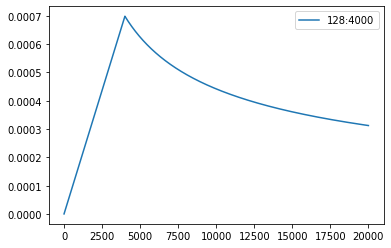

In [26]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=0.5, 
    warmup=4000, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 20000), [optimizer.rate(i) for i in range(1, 20000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

In [27]:
!nvidia-smi

Thu Feb  4 15:07:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070    On   | 00000000:01:00.0 Off |                  N/A |
| 17%   45C    P2    20W / 175W |    966MiB /  7979MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    On   | 00000000:03:00.0  On |                  N/A |
| 28%   

In [28]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("model: {}".format(model.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-02-04 15:07:17 | INFO | seq2seq | task: TranslationTask
2021-02-04 15:07:17 | INFO | seq2seq | model: Seq2Seq
2021-02-04 15:07:17 | INFO | seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2021-02-04 15:07:17 | INFO | seq2seq | optimizer: NoamOpt
2021-02-04 15:07:17 | INFO | seq2seq | num. model params: 2,844,928 (num. trained: 2,844,928)
2021-02-04 15:07:17 | INFO | seq2seq | max tokens per batch = 4096, accumulate steps = 4
2021-02-04 15:07:17 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[283679]
2021-02-04 15:07:17 | INFO | seq2seq | no checkpoint found!


train epoch 21:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:08:39 | INFO | seq2seq | training loss:	8.0312
2021-02-04 15:08:39 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:09:01 | INFO | seq2seq | example source: i keep telling my superego to back off and let me enjoy what i still have.
2021-02-04 15:09:01 | INFO | seq2seq | example hypothesis: UNKNOWNTOKENINHYP
2021-02-04 15:09:01 | INFO | seq2seq | example reference: 我總告訴自己的超我意識退下且讓我享受僅存的時間。
2021-02-04 15:09:01 | INFO | seq2seq | validation loss:	7.1266
2021-02-04 15:09:01 | INFO | seq2seq | BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 0.000 ratio = 0.035 hyp_len = 3426 ref_len = 96725)
2021-02-04 15:09:01 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint21.pt
2021-02-04 15:09:01 | INFO | seq2seq | end of epoch 21


train epoch 22:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:10:23 | INFO | seq2seq | training loss:	6.8430
2021-02-04 15:10:23 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:10:46 | INFO | seq2seq | example source: in october 2003, over 6,000 runners from 49 different nationalities came to the start line, all determined, and when the gunfire went off, this time it was a signal to run in harmony, for a change.
2021-02-04 15:10:46 | INFO | seq2seq | example hypothesis: 大大大大大大的,大大大大大大大,大大大大大大的的的的大大大大大大的的的。
2021-02-04 15:10:46 | INFO | seq2seq | example reference: 在2003年10月,超過六千名跑者從49個不同的國家來到這條起跑線前,堅定不移,當起跑的槍聲響起,這一次是為了和睦而奔跑,帶來改變的契機。
2021-02-04 15:10:46 | INFO | seq2seq | validation loss:	6.4470
2021-02-04 15:10:46 | INFO | seq2seq | BLEU = 0.28 8.2/1.1/0.1/0.0 (BP = 1.000 ratio = 1.288 hyp_len = 124570 ref_len = 96725)
2021-02-04 15:10:46 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint22.pt
2021-02-04 15:10:46 | INFO | seq2seq | end of epoch 22


train epoch 23:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:12:08 | INFO | seq2seq | training loss:	6.1932
2021-02-04 15:12:08 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:12:29 | INFO | seq2seq | example source: but we do have an unprecedented opportunity to try, and i believe we also, as adults, have a responsibility to do this.
2021-02-04 15:12:29 | INFO | seq2seq | example hypothesis: 但,我們需要有有有有有的,我們需要做,我們需要的,我們需要不見了。
2021-02-04 15:12:29 | INFO | seq2seq | example reference: 但這個機會前所未有,值得我們一試,我也認為,我們成人有責任要這麼做。
2021-02-04 15:12:29 | INFO | seq2seq | validation loss:	5.7531
2021-02-04 15:12:29 | INFO | seq2seq | BLEU = 1.52 19.7/4.0/0.9/0.2 (BP = 0.761 ratio = 0.786 hyp_len = 75980 ref_len = 96725)
2021-02-04 15:12:29 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint23.pt
2021-02-04 15:12:29 | INFO | seq2seq | end of epoch 23


train epoch 24:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:13:51 | INFO | seq2seq | training loss:	5.6899
2021-02-04 15:13:51 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:14:12 | INFO | seq2seq | example source: so because of these beauties -- the afsluitdijk: 32 kilometers, built by hand in 1932 -- we live with the water, we fight with the water, we try to find harmony, but sometimes we forget.
2021-02-04 15:14:12 | INFO | seq2seq | example hypothesis: 因為這些問題是,80000000000000000年,我們在水水裡,我們開始在水水裡,我們開始發現了。
2021-02-04 15:14:12 | INFO | seq2seq | example reference: 因為這些美──阿夫魯戴克大堤:32公里,1932年徒手建立──我們與水同住,我們與水相爭,我們試著找到和諧,但有時,我們會忘記。
2021-02-04 15:14:12 | INFO | seq2seq | validation loss:	5.3654
2021-02-04 15:14:12 | INFO | seq2seq | BLEU = 4.64 30.3/10.1/3.7/1.3 (BP = 0.748 ratio = 0.775 hyp_len = 74974 ref_len = 96725)
2021-02-04 15:14:12 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint24.pt
2021-02-04 15:14:12 | INFO | seq2seq | end of epoch 24


train epoch 25:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:15:34 | INFO | seq2seq | training loss:	5.3815
2021-02-04 15:15:34 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:15:54 | INFO | seq2seq | example source: and if the story is a good one, it might even make us smile.
2021-02-04 15:15:54 | INFO | seq2seq | example hypothesis: 如果故事是好好,可能是我們會把我們做好。
2021-02-04 15:15:54 | INFO | seq2seq | example reference: 而且如果這個故事好聽我們甚至會隨之微笑
2021-02-04 15:15:54 | INFO | seq2seq | validation loss:	5.0762
2021-02-04 15:15:54 | INFO | seq2seq | BLEU = 8.21 36.4/14.1/5.9/2.5 (BP = 0.883 ratio = 0.889 hyp_len = 86018 ref_len = 96725)
2021-02-04 15:15:54 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint25.pt
2021-02-04 15:15:54 | INFO | seq2seq | end of epoch 25


train epoch 26:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:17:16 | INFO | seq2seq | training loss:	5.1709
2021-02-04 15:17:16 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:17:37 | INFO | seq2seq | example source: that doesn’t mean the test itself is worthless— in fact, it does a good job of measuring the reasoning and problem-solving skills it sets out to.
2021-02-04 15:17:37 | INFO | seq2seq | example hypothesis: 這不是說的測試,無論是無限的,事實上,事實是很好的工作,解決問題和問題的,解決方案,解決方案的解決方案。
2021-02-04 15:17:37 | INFO | seq2seq | example reference: 那並不表示測驗本身毫無價值——事實上,它原本的目的是要測量推理和解決問題的技能,而在這方面它很成功。
2021-02-04 15:17:37 | INFO | seq2seq | validation loss:	4.8875
2021-02-04 15:17:37 | INFO | seq2seq | BLEU = 10.19 36.5/15.1/6.8/3.1 (BP = 0.979 ratio = 0.980 hyp_len = 94747 ref_len = 96725)
2021-02-04 15:17:37 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint26.pt
2021-02-04 15:17:37 | INFO | seq2seq | end of epoch 26


train epoch 27:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:18:59 | INFO | seq2seq | training loss:	5.0110
2021-02-04 15:18:59 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:19:19 | INFO | seq2seq | example source: and yet, for someone who's apparently done this already, i still haven't figured anything out yet.
2021-02-04 15:19:19 | INFO | seq2seq | example hypothesis: 然而,在某人身上,我還沒辦法做什麼,我仍然不知道任何任何東西。
2021-02-04 15:19:19 | INFO | seq2seq | example reference: 雖然我曾經出生過一次我還是什麼都不了解
2021-02-04 15:19:19 | INFO | seq2seq | validation loss:	4.7301
2021-02-04 15:19:19 | INFO | seq2seq | BLEU = 11.58 41.6/18.1/8.5/4.1 (BP = 0.907 ratio = 0.911 hyp_len = 88141 ref_len = 96725)
2021-02-04 15:19:19 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint27.pt
2021-02-04 15:19:19 | INFO | seq2seq | end of epoch 27


train epoch 28:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:20:40 | INFO | seq2seq | training loss:	4.8899
2021-02-04 15:20:40 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:21:01 | INFO | seq2seq | example source: the evolutionary role of the vulture is to rid the earth of harmful toxins produced following death.
2021-02-04 15:21:01 | INFO | seq2seq | example hypothesis: 溫度的溫度是地球的火箭,因因因因因因素產生死亡。
2021-02-04 15:21:01 | INFO | seq2seq | example reference: 禿鷲的進化作用是消除死屍產生的有害毒素。
2021-02-04 15:21:01 | INFO | seq2seq | validation loss:	4.6297
2021-02-04 15:21:01 | INFO | seq2seq | BLEU = 12.60 42.1/18.8/9.1/4.6 (BP = 0.936 ratio = 0.938 hyp_len = 90714 ref_len = 96725)
2021-02-04 15:21:02 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint28.pt
2021-02-04 15:21:02 | INFO | seq2seq | end of epoch 28


train epoch 29:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:22:23 | INFO | seq2seq | training loss:	4.8038
2021-02-04 15:22:23 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:22:44 | INFO | seq2seq | example source: they moved into one of our family apartments and treasured each day that they had, which were far too few.
2021-02-04 15:22:44 | INFO | seq2seq | example hypothesis: 他們搬到一家家家家家的家園,每天都走到他們,這太多了。
2021-02-04 15:22:44 | INFO | seq2seq | example reference: 他們搬進我們家庭套房,並且珍惜每一天,但是時間實在太少了。
2021-02-04 15:22:44 | INFO | seq2seq | validation loss:	4.5411
2021-02-04 15:22:44 | INFO | seq2seq | BLEU = 13.34 44.9/20.5/10.1/5.3 (BP = 0.897 ratio = 0.902 hyp_len = 87260 ref_len = 96725)
2021-02-04 15:22:44 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint29.pt
2021-02-04 15:22:44 | INFO | seq2seq | end of epoch 29


train epoch 30:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:24:06 | INFO | seq2seq | training loss:	4.7385
2021-02-04 15:24:06 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:24:26 | INFO | seq2seq | example source: she was admitted to the hospital, where an ultrasound confirmed what we already suspected: her heart had weakened to less than half its normal capacity and had ballooned into the distinctive shape of a takotsubo.
2021-02-04 15:24:26 | INFO | seq2seq | example hypothesis: 她必須承認醫院,在醫院裡,我們已經懷疑了:她的心靈感感感:她的心臟有一半正常的反應,除了一半正常的標準。
2021-02-04 15:24:26 | INFO | seq2seq | example reference: 她住院了,在醫院,超音波確認了我們的懷疑:她的心臟變弱了,只剩不到一半的正常能力,且鼓起來成為章魚壺的形狀。
2021-02-04 15:24:26 | INFO | seq2seq | validation loss:	4.4943
2021-02-04 15:24:26 | INFO | seq2seq | BLEU = 13.66 46.1/21.4/10.7/5.6 (BP = 0.876 ratio = 0.883 hyp_len = 85412 ref_len = 96725)
2021-02-04 15:24:26 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint30.pt
2021-02-04 15:24:26 | INFO | seq2seq | end of epoch 30


train epoch 31:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:25:48 | INFO | seq2seq | training loss:	4.6874
2021-02-04 15:25:48 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:26:08 | INFO | seq2seq | example source: now, cavefishes can tell me a lot about biology and geology.
2021-02-04 15:26:08 | INFO | seq2seq | example hypothesis: 克里斯可以告訴我生物學和喬治學。
2021-02-04 15:26:08 | INFO | seq2seq | example reference: 洞穴魚其實可以告訴我們許多生物學與地質學的故事。
2021-02-04 15:26:08 | INFO | seq2seq | validation loss:	4.4500
2021-02-04 15:26:08 | INFO | seq2seq | BLEU = 14.26 47.9/22.6/11.4/6.0 (BP = 0.865 ratio = 0.873 hyp_len = 84480 ref_len = 96725)
2021-02-04 15:26:08 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint31.pt
2021-02-04 15:26:08 | INFO | seq2seq | end of epoch 31


train epoch 32:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:27:30 | INFO | seq2seq | training loss:	4.6446
2021-02-04 15:27:30 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:27:51 | INFO | seq2seq | example source: i saw chains of jellyfish called siphonophores that were longer than this room, pumping out so much light that i could read the dials and gauges inside the suit without a flashlight; and puffs and billows of what looked like luminous blue smoke; and explosions of sparks that would swirl up out of the thrusters -- just like when you throw a log on a campfire and the embers swirl up off the campfire, but these were icy, blue embers.
2021-02-04 15:27:51 | INFO | seq2seq | example hypothesis: 我看到了jyyyyyyyyyyyy的椅子,希望我能閱讀數位的光線,光是沒有閃亮的,光亮亮的藍色,看起來像藍色的藍色,紅色的藍色的藍色。
2021-02-04 15:27:51 | INFO | seq2seq | example reference: 我看到一連串稱為「管水母」的生物排成的水母鏈比這個房間還長發出的光之多即使在潛水裝裡不開手電筒我也看得到刻度跟儀表板的數字還有一陣陣大小翻騰看起來像藍色螢光的煙霧或是像從推進器渦旋而出蹦開的火花就像你丟一塊木頭到營火裡,火花霹啪往上竄,只不過這些是冰冷的藍色火光
2021-02-04 15:27:51 | INFO | seq2seq | validation loss:	4.4020
2021-02-04 15:27:51 | INFO | seq2seq | BLEU = 14.60 47.5/22.6/11.5/6.1 (BP = 0.881 ratio = 0.887 hyp_len = 85824 ref_len = 96725)


train epoch 33:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:29:13 | INFO | seq2seq | training loss:	4.6083
2021-02-04 15:29:13 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:29:33 | INFO | seq2seq | example source: gh: it turns out putting diapers on your head and play-fighting until the kids fall asleep is a great way to love your kids.
2021-02-04 15:29:33 | INFO | seq2seq | example hypothesis: 克:結果發現在你的頭和玩耍,直到孩子睡眠時,睡眠是很棒的方式。
2021-02-04 15:29:33 | INFO | seq2seq | example reference: 亨利:事實證明,頭戴尿布,打打鬧鬧,玩到孩子們入睡為止,是愛你孩子的好方法。
2021-02-04 15:29:33 | INFO | seq2seq | validation loss:	4.3664
2021-02-04 15:29:33 | INFO | seq2seq | BLEU = 15.09 49.3/23.6/12.1/6.5 (BP = 0.867 ratio = 0.875 hyp_len = 84639 ref_len = 96725)
2021-02-04 15:29:33 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint33.pt
2021-02-04 15:29:33 | INFO | seq2seq | end of epoch 33


train epoch 34:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:30:55 | INFO | seq2seq | training loss:	4.5749
2021-02-04 15:30:55 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:31:15 | INFO | seq2seq | example source: there are many eyes to spot danger.
2021-02-04 15:31:15 | INFO | seq2seq | example hypothesis: 許多眼睛有許多眼睛。
2021-02-04 15:31:15 | INFO | seq2seq | example reference: 有很多眼睛可以看到危險。
2021-02-04 15:31:15 | INFO | seq2seq | validation loss:	4.3337
2021-02-04 15:31:15 | INFO | seq2seq | BLEU = 15.59 49.6/23.9/12.4/6.7 (BP = 0.881 ratio = 0.887 hyp_len = 85833 ref_len = 96725)
2021-02-04 15:31:15 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint34.pt
2021-02-04 15:31:15 | INFO | seq2seq | end of epoch 34


train epoch 35:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:32:37 | INFO | seq2seq | training loss:	4.5443
2021-02-04 15:32:37 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:32:58 | INFO | seq2seq | example source: very critically, how do we protect it, if we find it, and not contaminate it?
2021-02-04 15:32:58 | INFO | seq2seq | example hypothesis: 非常重要的是,我們要如何保護它,如果我們找到它,不是把它打算呢?
2021-02-04 15:32:58 | INFO | seq2seq | example reference: 非常關鍵的一點是,當我們發現生命了之後,應該要怎樣保護它並使它免於污染?
2021-02-04 15:32:58 | INFO | seq2seq | validation loss:	4.3010
2021-02-04 15:32:58 | INFO | seq2seq | BLEU = 16.22 49.4/24.0/12.5/6.9 (BP = 0.909 ratio = 0.913 hyp_len = 88271 ref_len = 96725)
2021-02-04 15:32:58 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint35.pt
2021-02-04 15:32:58 | INFO | seq2seq | end of epoch 35


train epoch 36:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:34:20 | INFO | seq2seq | training loss:	4.5160
2021-02-04 15:34:20 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:34:41 | INFO | seq2seq | example source: i found that with whatever risk or gamble i took in putting my face out there, it was well worth any negative comment, any flak i received, because i felt i was able to make this real and this tangible impact.
2021-02-04 15:34:41 | INFO | seq2seq | example hypothesis: 我發現,有無論風險,或是我把我的臉上放出來,它很糟糕,任何負面的衝擊,因為我覺得我可以讓這個真正的影響。
2021-02-04 15:34:41 | INFO | seq2seq | example reference: 我發現,當我公開我的臉孔,不論我冒什麼風險或賭上什麼,任何負面評論都值得,我受到的任何抨擊都值得,因為我覺得我能夠造成這真實、有形的影響。
2021-02-04 15:34:41 | INFO | seq2seq | validation loss:	4.2742
2021-02-04 15:34:41 | INFO | seq2seq | BLEU = 16.15 51.1/24.9/13.0/7.1 (BP = 0.871 ratio = 0.879 hyp_len = 85006 ref_len = 96725)
2021-02-04 15:34:41 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint36.pt
2021-02-04 15:34:41 | INFO | seq2seq | end of epoch 36


train epoch 37:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:36:03 | INFO | seq2seq | training loss:	4.4934
2021-02-04 15:36:03 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:36:23 | INFO | seq2seq | example source: my parents were fanatics about learning, and i'll come back to that a little bit later.
2021-02-04 15:36:23 | INFO | seq2seq | example hypothesis: 我的父母很熟悉學習,我會回來這一點。
2021-02-04 15:36:23 | INFO | seq2seq | example reference: 我父母非常熱衷學習關於這,我以後再來説
2021-02-04 15:36:23 | INFO | seq2seq | validation loss:	4.2529
2021-02-04 15:36:23 | INFO | seq2seq | BLEU = 16.73 50.2/24.6/12.9/7.1 (BP = 0.912 ratio = 0.916 hyp_len = 88586 ref_len = 96725)
2021-02-04 15:36:23 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint37.pt
2021-02-04 15:36:23 | INFO | seq2seq | end of epoch 37


train epoch 38:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:37:45 | INFO | seq2seq | training loss:	4.4724
2021-02-04 15:37:45 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:38:03 | INFO | seq2seq | example source: the educated blamed the less well-educated.
2021-02-04 15:38:03 | INFO | seq2seq | example hypothesis: 教育的廣告是較少的。
2021-02-04 15:38:03 | INFO | seq2seq | example reference: 知識分子指責未受良好教育的人。
2021-02-04 15:38:03 | INFO | seq2seq | validation loss:	4.2432
2021-02-04 15:38:03 | INFO | seq2seq | BLEU = 16.56 52.7/26.1/13.8/7.7 (BP = 0.846 ratio = 0.856 hyp_len = 82831 ref_len = 96725)
2021-02-04 15:38:03 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint38.pt
2021-02-04 15:38:03 | INFO | seq2seq | end of epoch 38


train epoch 39:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:39:25 | INFO | seq2seq | training loss:	4.4555
2021-02-04 15:39:25 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:39:44 | INFO | seq2seq | example source: my announcement was just two lines in a chat channel.
2021-02-04 15:39:44 | INFO | seq2seq | example hypothesis: 我的創意只有兩條條線。
2021-02-04 15:39:44 | INFO | seq2seq | example reference: 我只是在一個聊天管道上寫了兩行文字。
2021-02-04 15:39:44 | INFO | seq2seq | validation loss:	4.2345
2021-02-04 15:39:44 | INFO | seq2seq | BLEU = 16.24 53.7/26.8/14.3/7.9 (BP = 0.808 ratio = 0.824 hyp_len = 79713 ref_len = 96725)
2021-02-04 15:39:44 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint39.pt
2021-02-04 15:39:44 | INFO | seq2seq | end of epoch 39


train epoch 40:   0%|          | 0/660 [00:00<?, ?it/s]

2021-02-04 15:41:06 | INFO | seq2seq | training loss:	4.4412
2021-02-04 15:41:06 | INFO | seq2seq | begin validation


validation:   0%|          | 0/35 [00:00<?, ?it/s]

2021-02-04 15:41:26 | INFO | seq2seq | example source: and what these women understood is sometimes the most important things that we do and that we spend our time on are those things that we cannot measure.
2021-02-04 15:41:26 | INFO | seq2seq | example hypothesis: 而這些女性了解的是,有時我們所做的最重要的事,我們花了時間,是我們無法測量的事物。
2021-02-04 15:41:26 | INFO | seq2seq | example reference: 這些婦女明白到有時候我們做最重要的事和我們花上最多的時間就是那些我們無法衡量的東西。
2021-02-04 15:41:26 | INFO | seq2seq | validation loss:	4.2022
2021-02-04 15:41:26 | INFO | seq2seq | BLEU = 17.12 52.5/26.1/13.9/7.8 (BP = 0.872 ratio = 0.879 hyp_len = 85035 ref_len = 96725)
2021-02-04 15:41:26 | INFO | seq2seq | saved epoch checkpoint:	/home/george/Projects/mlta2021/checkpoints-transformer/checkpoint40.pt
2021-02-04 15:41:26 | INFO | seq2seq | end of epoch 40


In [29]:
!ls checkpoints-rnn

ls: cannot access 'checkpoints-rnn': No such file or directory


In [30]:
# Path(savedir).mkdir(parents=True, exist_ok=True)
# torch.save(model.state_dict(), Path(savedir)/"checkpoint99.pt")

In [31]:
# model.load_state_dict(torch.load(Path(savedir)/"checkpoint19.pt"))

In [32]:
# validate_and_save(model, task, criterion, epoch=1)

In [33]:
# check.keys()

In [34]:
# validate_and_save(model, task, criterion)

In [35]:
# check['args'].langs

In [36]:
# from fairseq.tasks.translation_from_pretrained_bart import TranslationFromPretrainedBARTTask
# task_cfg = TranslationConfig(
#     data=datadir,
#     source_lang=src,
#     target_lang=tgt,
#     train_subset="train",
#     required_seq_len_multiple=8,
#     dataset_impl="mmap",
# )
# task_cfg = Namespace(
#     **vars(task_cfg),
#     langs="en_XX,zh_CN",
#     prepend_bos=True
# )
# task = TranslationFromPretrainedBARTTask.setup_task(task_cfg)

# 成對雙語言資料
* iwslt17
* UM-Corpus的子集
    - 新聞: 450,000句
    - 口語: 220,000句
    - 教育: 450,000句
    - 字幕: 300,000 (含TED)
* TED2020 http://opus.nlpl.eu/TED2020-v1.php, 
    - 原資料量: 404,726句
    - 訓練資料: 335,785句
* OpenSubtitles http://opus.nlpl.eu/OpenSubtitles-v2018.php, http://www.opensubtitles.org/
    - 訓練資料: 4,772,273句
    
J. Tiedemann, 2012, Parallel Data, Tools and Interfaces in OPUS. In Proceedings of the 8th International Conference on Language Resources and Evaluation (LREC 2012)

# 中文單語言資料
- newscrawl資料集 (wmt19提供):
  - 2018訓練資料：589,475句
  - 2019訓練資料：2,974,040句
    
- 語言
  - 繁體中文: news.201X.zh.shuffled.deduped.trad (使用opencc轉換 簡->繁)

In [37]:
task.target_dictionary.eos()

2

In [38]:
itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)

In [39]:
sample = next(itr)

In [40]:
sample['target'][0]

tensor([  40, 1245,  229, 1262,    2,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1])

In [41]:
sample['net_input']['prev_output_tokens'][0]

tensor([   2,   40, 1245,  229, 1262,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1])